In [1]:
import xarray as xr
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from matplotlib.cm import get_cmap
import matplotlib.colors as mcolors
import matplotlib.gridspec as gridspec
from matplotlib.colors import LinearSegmentedColormap
from matplotlib import ticker

import cartopy.crs as ccrs
import cartopy.feature as cfeature

import metpy.calc as mpcalc
from metpy.interpolate import cross_section
import xwrf 

from metpy.plots import USCOUNTIES
import pickle


In [67]:
init = pd.Timestamp(2022,12,21,18)
fcst_end = init + pd.Timedelta(hours=10)

### time to plot
#output_time = pd.Timestamp(2022,12,21,22,50)
output_time = pd.Timestamp(2022,12,21,23,30)

# wrf filename matching this time
wrf_filename = "/schumacher-scratch3/rschumac/flood/ere_cases/WRFV4/2022122118_hrrr_2dom_600m/wrfout_d02_"+output_time.strftime("%Y-%m-%d_%H:%M:%S")

wrf_filename

'/schumacher-scratch3/rschumac/flood/ere_cases/WRFV4/2022122118_hrrr_2dom_600m/wrfout_d02_2022-12-21_23:30:00'

In [68]:
wrfin = xr.open_dataset(wrf_filename).xwrf.postprocess()

In [69]:
wrfin

<xarray.Dataset> Size: 5GB
Dimensions:                    (Time: 1, y: 790, x: 670, soil_layers_stag: 4,
                                z: 85, x_stag: 671, y_stag: 791, z_stag: 86,
                                pft_fraction_stag: 17, seed_dim_stag: 34)
Coordinates: (12/15)
    XLAT                       (y, x) float32 2MB 38.01 38.01 ... 42.23 42.23
    XLONG                      (y, x) float32 2MB -106.4 -106.4 ... -101.6
    XTIME                      (Time) datetime64[ns] 8B ...
    XLAT_U                     (y, x_stag) float32 2MB 38.01 38.01 ... 42.23
    XLONG_U                    (y, x_stag) float32 2MB -106.4 -106.4 ... -101.6
    XLAT_V                     (y_stag, x) float32 2MB 38.01 38.01 ... 42.23
    ...                         ...
  * z_stag                     (z_stag) float32 344B 1.0 0.9938 ... 0.002003 0.0
  * Time                       (Time) datetime64[ns] 8B 2022-12-21T23:30:00
  * y                          (y) float64 6kB -3.312e+05 ... 1.422e+05
  * x                          (x) float64 5kB -1.227e+05 ... 2.787e+05
  * y_stag                     (y_stag) float64 6kB -3.315e+05 ... 1.425e+05
  * x_stag                     (x_stag) float64 5kB -1.23e+05 ... 2.79e+05
Dimensions without coordinates: soil_layers_stag, pft_fraction_stag,
                                seed_dim_stag
Data variables: (12/208)
    Times                      (Time) |S19 19B b'2022-12-21_23:30:00'
    LU_INDEX                   (Time, y, x) float32 2MB ...
    ZS                         (Time, soil_layers_stag) float32 16B ...
    DZS                        (Time, soil_layers_stag) float32 16B ...
    VAR_SSO                    (Time, y, x) float32 2MB ...
    U                          (Time, z, y, x_stag) float32 180MB ...
    ...                         ...
    geopotential_height        (Time, z_stag, y, x) float32 182MB 3.074e+03 ....
    wind_east                  (Time, z, y, x) float32 180MB 8.574 ... 25.24
    wind_north                 (Time, z, y, x) float32 180MB -2.347 ... -2.993
    wind_east_10               (Time, y, x) float32 2MB 6.723 6.879 ... 1.8
    wind_north_10              (Time, y, x) float32 2MB -1.841 -1.765 ... -8.742
    wrf_projection             object 8B +proj=lcc +x_0=0 +y_0=0 +a=6370000 +...
Attributes: (12/131)
    TITLE:                            OUTPUT FROM WRF V4.3 MODEL
    START_DATE:                      2022-12-21_18:00:00
    SIMULATION_START_DATE:           2022-12-21_18:00:00
    WEST-EAST_GRID_DIMENSION:        671
    SOUTH-NORTH_GRID_DIMENSION:      791
    BOTTOM-TOP_GRID_DIMENSION:       86
    ...                              ...
    ISLAKE:                          21
    ISICE:                           15
    ISURBAN:                         13
    ISOILWATER:                      14
    HYBRID_OPT:                      2
    ETAC:                            0.2

In [70]:
subset_vars = ['HGT','air_potential_temperature','geopotential_height','air_pressure','T2','U10','V10','W',
              'wrf_projection','wind_east','wind_north']
wrf_subset = wrfin[subset_vars].squeeze().xwrf.destagger()

wrf_subset['t2c'] = wrf_subset['T2'].metpy.convert_units('degC') 
wrf_subset['wspd'] = mpcalc.wind_speed(wrf_subset.wind_east, wrf_subset.wind_north)

In [71]:
wrf_subset

<xarray.Dataset> Size: 1GB
Dimensions:                    (y: 790, x: 670, z: 85, z_stag: 86)
Coordinates:
    XLAT                       (y, x) float32 2MB 38.01 38.01 ... 42.23 42.23
    XLONG                      (y, x) float32 2MB -106.4 -106.4 ... -101.6
    XTIME                      datetime64[ns] 8B ...
    CLAT                       (y, x) float32 2MB 38.01 38.01 ... 42.23 42.23
  * z                          (z) float32 340B 0.9969 0.9899 ... 0.001002
  * z_stag                     (z_stag) float32 344B 1.0 0.9938 ... 0.002003 0.0
    Time                       datetime64[ns] 8B 2022-12-21T23:30:00
  * y                          (y) float64 6kB -3.312e+05 ... 1.422e+05
  * x                          (x) float64 5kB -1.227e+05 ... 2.787e+05
Data variables: (12/13)
    HGT                        (y, x) float32 2MB ...
    air_potential_temperature  (z, y, x) float32 180MB 298.4 298.4 ... 488.5
    geopotential_height        (z, y, x) float32 180MB 3.097e+03 ... 1.999e+04
    air_pressure               (z, y, x) float32 180MB 6.915e+04 ... 5.096e+03
    T2                         (y, x) float32 2MB 268.4 268.5 ... 247.6 247.6
    U10                        (y, x) float32 2MB ...
    ...                         ...
    W                          (z, y, x) float32 180MB 0.06745 ... -0.01204
    wrf_projection             object 8B +proj=lcc +x_0=0 +y_0=0 +a=6370000 +...
    wind_east                  (z, y, x) float32 180MB 8.574 8.761 ... 25.24
    wind_north                 (z, y, x) float32 180MB -2.347 -2.243 ... -2.993
    t2c                        (y, x) float32 2MB <Quantity([[ -4.733429   -4...
    wspd                       (z, y, x) float32 180MB <Quantity([[[ 8.88888 ...
Attributes: (12/131)
    TITLE:                            OUTPUT FROM WRF V4.3 MODEL
    START_DATE:                      2022-12-21_18:00:00
    SIMULATION_START_DATE:           2022-12-21_18:00:00
    WEST-EAST_GRID_DIMENSION:        671
    SOUTH-NORTH_GRID_DIMENSION:      791
    BOTTOM-TOP_GRID_DIMENSION:       86
    ...                              ...
    ISLAKE:                          21
    ISICE:                           15
    ISURBAN:                         13
    ISOILWATER:                      14
    HYBRID_OPT:                      2
    ETAC:                            0.2

In [72]:
#### assign metpy CRS using the metadata
wrf_subset = wrf_subset.metpy.assign_crs(
    grid_mapping_name=wrf_subset.wrf_projection.attrs['grid_mapping_name'],
    latitude_of_projection_origin=wrf_subset.wrf_projection.attrs['latitude_of_projection_origin'],
    longitude_of_central_meridian=wrf_subset.wrf_projection.attrs['longitude_of_central_meridian'],
    standard_parallel=wrf_subset.wrf_projection.attrs['standard_parallel'],
    earth_radius=wrf_subset.wrf_projection.attrs['semi_major_axis']
)

### Define the lat/lon endpoints of our cross-section

In [73]:
### define cross-section line

### 2300
### weld county
start = (39.97,-104.88)
end = (40.58, -104.30)

### farther south
#start = (39.4, -104.25)
#end = (40.25, -103.6)

### Use MetPy's cross-section method to calculate the quantities along our specified line

In [74]:
cross = cross_section(wrf_subset, start, end).set_coords(('XLAT', 'XLONG'))
### expand the longitude array dims to allow for plotting of hybrid data
cross['longitude2d'] = cross.XLONG.expand_dims({'sigma':cross.z.shape[0]})

/home/rschumac/miniforge3/envs/flood_apr2024/lib/python3.12/site-packages/xarray/core/dataset.py:6924: UserWarning: More than one latitude coordinate present for variable  "HGT".
  k: maybe_wrap_array(v, func(v, *args, **kwargs))
/home/rschumac/miniforge3/envs/flood_apr2024/lib/python3.12/site-packages/xarray/core/dataset.py:6924: UserWarning: More than one time coordinate present for variable  "HGT".
  k: maybe_wrap_array(v, func(v, *args, **kwargs))


In [75]:
cross

Magnitude,[5.059859798459626 5.095375096201929 5.130798665998364 5.160744777400418 5.385387614739156 5.44913353086514 5.708533877363384 5.404611539876416 5.659027422911307 5.044840851389839 5.123412308280807 4.944625739286155 4.989184684359126 4.60808913508111 3.839891370141955 3.4573634529886137 3.458349108254629 3.426398549778118 3.3194460016008307 3.463079265761829 1.8643967388666232 -6.827261554228729 -7.774780025517914 -8.472534864876721 -8.898619542725342 -9.35429184673915 -9.765818676371135 -10.100948754655239 -10.030752872863484 -9.491254044740222 -9.441557407370782 -10.015331801610067 -10.169349832919789 -10.054639406315463 -9.738476530383453 -9.451851710161726 -9.185159631470246 -9.19583437309337 -9.059701823777491 -8.800571249110465 -8.932610624704312 -9.489059580151475 -9.874962058327087 -9.856317652592754 -10.495311795249837 -11.301412924036166 -11.741507703141991 -11.883383963035985 -11.80797911220219 -11.558862833568389 -11.267913766044874 -11.384375659882439 -11.452229736132812 -11.313424851175888 -11.27920353187863 -11.358604946178728 -11.477697033486827 -11.551461382271858 -11.65847686724269 -11.679055368773577 -11.713217152708486 -11.908754568552522 -12.024414523650346 -12.123810573868901 -12.275982796992825 -12.313300263358304 -12.370432116886537 -12.444287125860814 -12.441967648342851 -12.650819248609874 -13.321293301919416 -13.899782556275163 -14.277394537889315 -14.410624461459324 -14.459909830052629 -14.504905372453926 -14.469692890631269 -14.305246100823046 -14.306100208756229 -14.37026572697828 -14.361492901396025 -14.174498014674821 -14.086093195564658 -14.212231672358689 -14.314549023680277 -14.430666568119843 -14.564634055012053 -14.663210094735796 -14.762734705324442 -14.821704087826069 -14.829956236118921 -14.876526371929799 -14.95602383658294 -15.091984207055232 -15.190542093416095 -15.289475138898714 -16.06750554810749 -16.005876942012588 -15.77600704804231 -15.57258021295636]
Units,degree_Celsius
Magnitude,[[12.435226547119417 12.5378796531731 13.708062523237931 ... 13.01637399267579 13.228862233461214 13.449169819198872] [15.583493106839159 15.61382522303091 17.180903680080732 ... 16.33971733754829 16.49294578801464 16.65101578204291] [18.55800971692502 18.538973073006602 19.438768277321522 ... 18.046313430810578 18.371985204378937 18.643003357986508] ... [19.63808248702948 19.84376102556874 20.04760676952842 ... 22.959654438189734 22.91015681559541 22.88530141624369] [21.828473541301236 22.02404113240688 22.216835495017346 ... 24.0308732163309 24.01043552500744 23.993622758526072] [23.760318340600097 23.951815917967217 24.14781925993329 ... 25.495661356155495 25.47887747201775 25.45323610655628]]
Units,meter/second


### also calculate the normal/tangential wind components with metpy

In [76]:
cross['t_wind'], cross['n_wind'] = mpcalc.cross_section_components(
    cross['wind_east'],
    cross['wind_north'])

cross

Magnitude,[5.059859798459626 5.095375096201929 5.130798665998364 5.160744777400418 5.385387614739156 5.44913353086514 5.708533877363384 5.404611539876416 5.659027422911307 5.044840851389839 5.123412308280807 4.944625739286155 4.989184684359126 4.60808913508111 3.839891370141955 3.4573634529886137 3.458349108254629 3.426398549778118 3.3194460016008307 3.463079265761829 1.8643967388666232 -6.827261554228729 -7.774780025517914 -8.472534864876721 -8.898619542725342 -9.35429184673915 -9.765818676371135 -10.100948754655239 -10.030752872863484 -9.491254044740222 -9.441557407370782 -10.015331801610067 -10.169349832919789 -10.054639406315463 -9.738476530383453 -9.451851710161726 -9.185159631470246 -9.19583437309337 -9.059701823777491 -8.800571249110465 -8.932610624704312 -9.489059580151475 -9.874962058327087 -9.856317652592754 -10.495311795249837 -11.301412924036166 -11.741507703141991 -11.883383963035985 -11.80797911220219 -11.558862833568389 -11.267913766044874 -11.384375659882439 -11.452229736132812 -11.313424851175888 -11.27920353187863 -11.358604946178728 -11.477697033486827 -11.551461382271858 -11.65847686724269 -11.679055368773577 -11.713217152708486 -11.908754568552522 -12.024414523650346 -12.123810573868901 -12.275982796992825 -12.313300263358304 -12.370432116886537 -12.444287125860814 -12.441967648342851 -12.650819248609874 -13.321293301919416 -13.899782556275163 -14.277394537889315 -14.410624461459324 -14.459909830052629 -14.504905372453926 -14.469692890631269 -14.305246100823046 -14.306100208756229 -14.37026572697828 -14.361492901396025 -14.174498014674821 -14.086093195564658 -14.212231672358689 -14.314549023680277 -14.430666568119843 -14.564634055012053 -14.663210094735796 -14.762734705324442 -14.821704087826069 -14.829956236118921 -14.876526371929799 -14.95602383658294 -15.091984207055232 -15.190542093416095 -15.289475138898714 -16.06750554810749 -16.005876942012588 -15.77600704804231 -15.57258021295636]
Units,degree_Celsius
Magnitude,[[12.435226547119417 12.5378796531731 13.708062523237931 ... 13.01637399267579 13.228862233461214 13.449169819198872] [15.583493106839159 15.61382522303091 17.180903680080732 ... 16.33971733754829 16.49294578801464 16.65101578204291] [18.55800971692502 18.538973073006602 19.438768277321522 ... 18.046313430810578 18.371985204378937 18.643003357986508] ... [19.63808248702948 19.84376102556874 20.04760676952842 ... 22.959654438189734 22.91015681559541 22.88530141624369] [21.828473541301236 22.02404113240688 22.216835495017346 ... 24.0308732163309 24.01043552500744 23.993622758526072] [23.760318340600097 23.951815917967217 24.14781925993329 ... 25.495661356155495 25.47887747201775 25.45323610655628]]
Units,meter/second
Magnitude,[[6.507928578387981 6.368793380923492 7.13937963970691 ... -12.717406563870911 -12.863949556020538 -13.019953423667255] [8.612392375764509 8.418411328088796 9.355580017008224 ... -16.00093263684577 -16.071270815337822 -16.14621146520912] [10.782369212667744 10.613613998212367 11.055125422756852 ... -17.67517707234447 -17.89602524005334 -18.058369931971285] ... [15.263203065760603 15.42946935707984 15.593325519758654 ... 16.717952051351926 16.66668001532446 16.641401641834136] [16.485743095443468 16.60331809605871 16.720572611001277 ... 16.58739687289248 16.5566140798557 16.536472222517975] [19.01304761059464 19.09175341962105 19.170083326704862 ... 17.148827043934695 17.116681096784365 17.089942866228643]]
Units,dimensionless
Magnitude,[[-10.595494576843985 -10.799754853900938 -11.701079069905306 ... -2.771224381508569 -3.081374091742161 -3.36839304693141] [-12.986851314413054 -13.149823591095531 -14.409848060790827 ... -3.30311683234844 -3.6946574549087066 -4.062715738758343] [-15.104212365165186 -15.199986672503643 -15.988911991452206 ... -3.6255278728086946 -4.135056086123059 -4.621120166468162] ... [-12.356698755677723 -12.478207145769776 -12.599777240142927 ... -15.737081914781744 -15.71931607648952 -15.709894150741656] [-14.30742339804032 -14.470244016774211 -14.62

### first plot a map of 2-m temp with the cross-section location

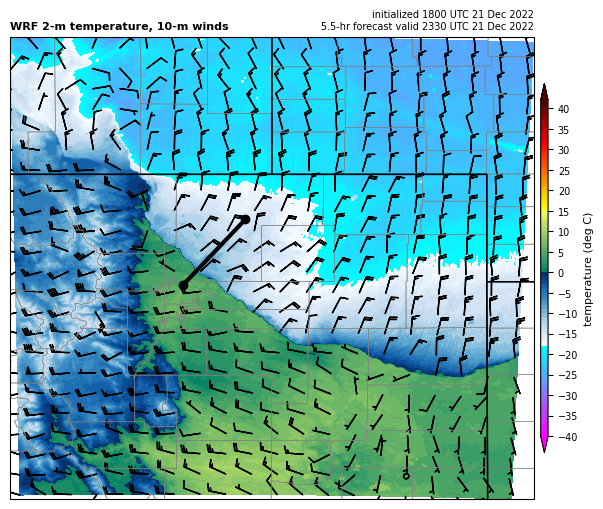

In [77]:
## get time and forecast lead info
vtime = pd.to_datetime(wrf_subset.Time.values)
#lead = int((vtime - init).total_seconds() // 3600)
lead = (vtime - init).total_seconds() / 3600

# Set Projection of Plot
fig = plt.figure(figsize=(9,6))
#add_metpy_logo(fig, 1775, 170, size='large')
ax = fig.add_subplot(1, 1, 1, projection=ccrs.PlateCarree())

# Set plot bounds -- or just comment this out if wanting to plot the full domain
#ax.set_extent((-110, -100, 37., 42.5))
#ax.set_extent((-88.5, -80.5, 35,39.25))

# Add some various map elements to the plot to make it recognizable.
#ax.add_feature(cfeature.LAND.with_scale('10m'))
ax.add_feature(USCOUNTIES.with_scale('5m'), edgecolor="gray", linewidth=0.4)
ax.add_feature(cfeature.STATES.with_scale('10m'))
ax.add_feature(cfeature.BORDERS.with_scale('10m'))

### temperature contour levels & color scale
#clevs = np.arange(-40,110,2)  ### range of temperatures
clevs = np.arange(-40, 43, 1)

#### read in colormap
#fp = open('/Users/rschumac/research/real_time/functions_rtwx/sfc_temp_cmap.pkl', 'rb')
fp = open('sfc_temp_cmap.pkl', 'rb')
sfc_temp_cmap = pickle.load(fp)
fp.close()

cf = ax.contourf(wrf_subset.XLONG, wrf_subset.XLAT,
                 wrf_subset.t2c,
                 clevs,
                 cmap=sfc_temp_cmap, 
                 #alpha=0.7,
                 extend='both',
                 transform_first=True,
                 transform=ccrs.PlateCarree())
cb = plt.colorbar(cf, orientation='vertical', pad=0.01,
                  shrink=0.8, aspect=50)
cb.set_label('temperature (deg C)', fontsize=8)
cb.ax.locator_params(nbins=20)
cb.ax.tick_params(labelsize=7)

# Add the 10-m wind barbs, only plotting every 15th data point.
wind_slice = (slice(None, None, 35), slice(None,None,35))
plt.barbs(wrf_subset.XLONG[wind_slice].values, wrf_subset.XLAT[wind_slice].values,
          wrf_subset.U10[wind_slice].metpy.convert_units('kt').values, 
          wrf_subset.V10[wind_slice].metpy.convert_units('kt').values,
          transform=ccrs.PlateCarree(), length=5)

ax.plot([start[1], end[1]],
            [start[0],end[0]], color="black", marker="o",
            transform=ccrs.PlateCarree(), zorder=3, linewidth=3)

## add location of tslist points
#lat_points = [44.046,44.617,45.084,45.022,45.521,45.683,46.045] 
#lon_points = [-103.060,-102.900,-102.266,-101.836,-100.512,-100.320,-99.802]
#names = ['rap','sd1','sd2','sd3','sd4','sd5','sd6']
#nums = [0,1,2,3,4,5,6]
#ax.scatter(lon_points,lat_points,15,
#     color='magenta', marker='o', 
#     transform=ccrs.PlateCarree())

# add titles
plt.title("WRF 2-m temperature, 10-m winds",
          loc='left', weight='bold', fontsize=8)
plt.title("initialized "+init.strftime("%H%M UTC %d %b %Y")+"\n"+str(lead)+"-hr forecast valid "+vtime.strftime("%H%M UTC %d %b %Y"), 
      loc='right', fontsize=7)

plt.show()

#fig.savefig("t2m_xsecline_"+init.strftime("%Y%m%d%H")+"_f"+str(lead).zfill(3)+".png",
#           bbox_inches='tight',dpi=255,transparent=False,facecolor='white')

plt.close('all')



### now plot the cross-section

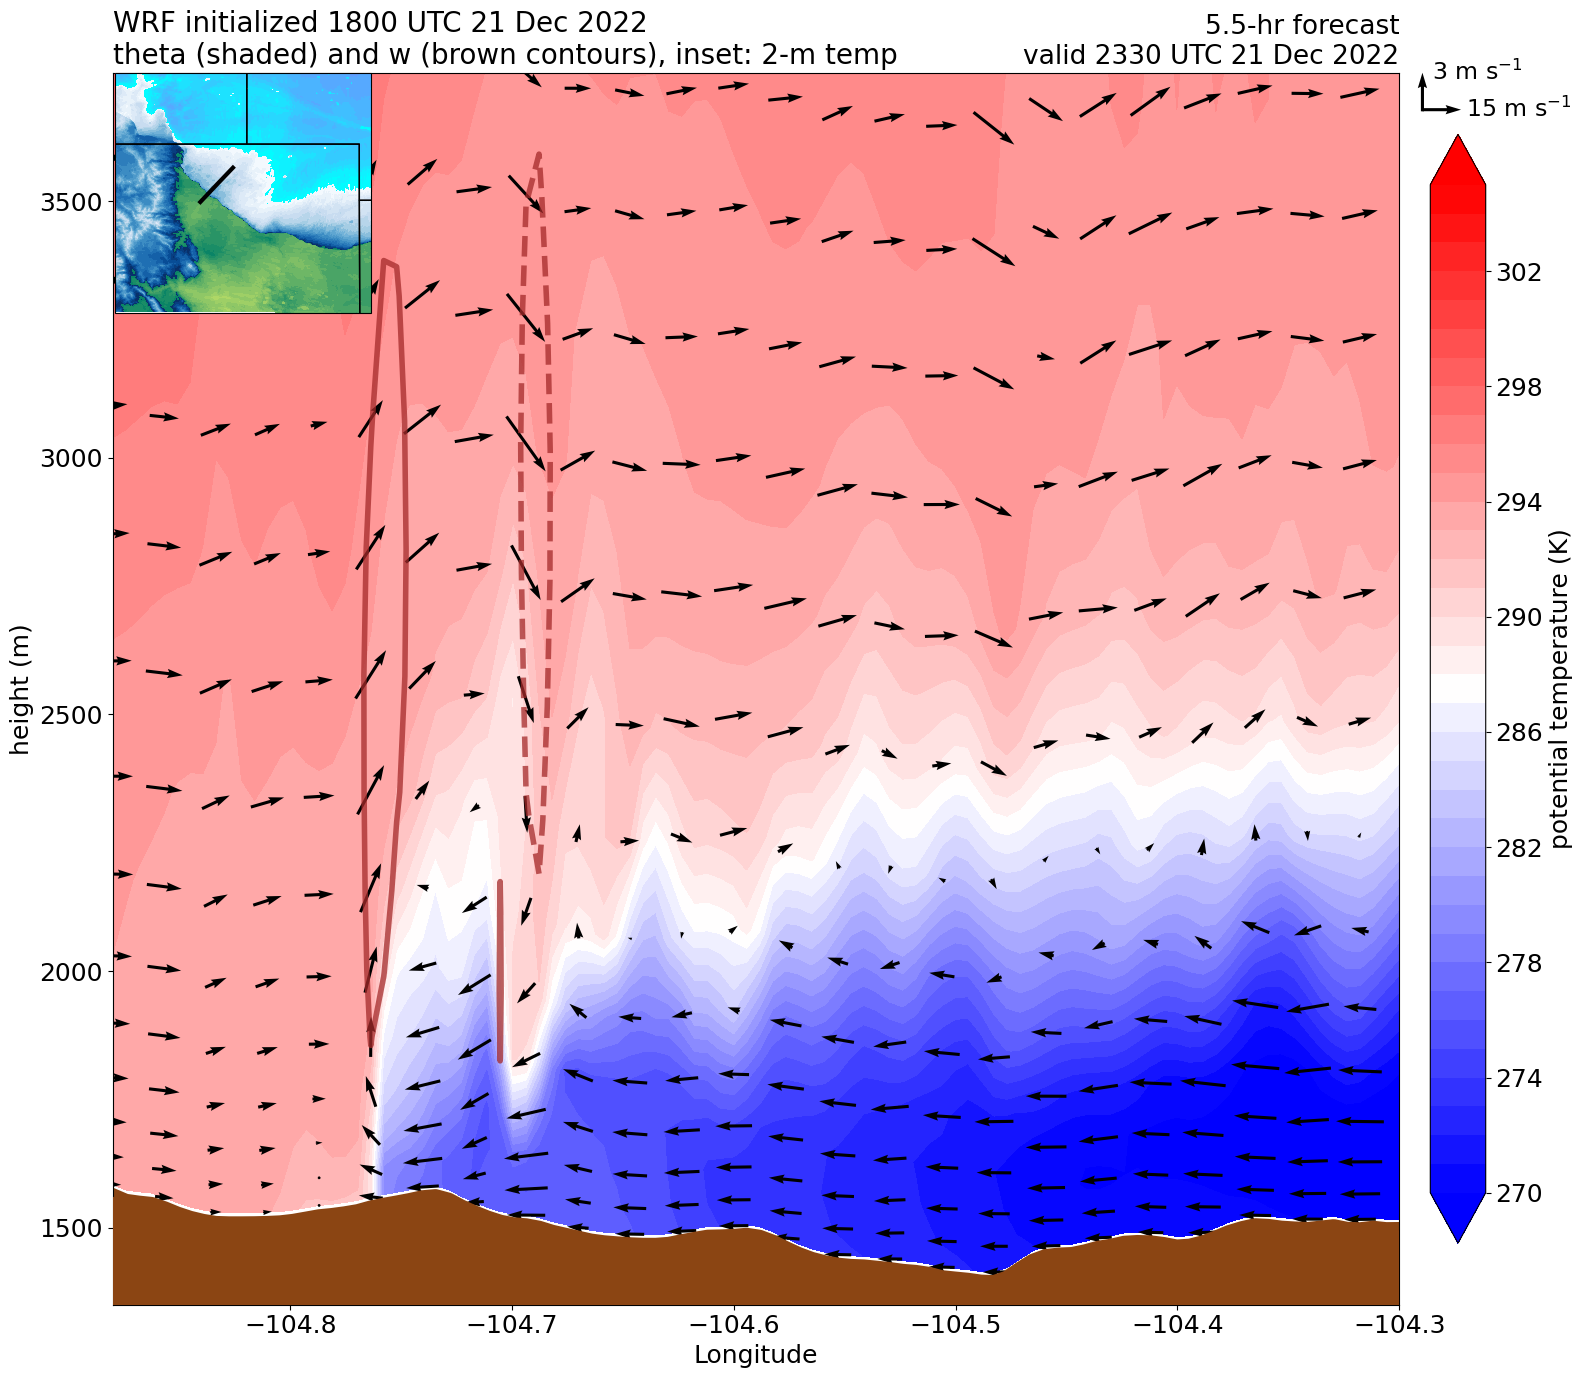

In [79]:
# Define the figure object and primary axes
fig = plt.figure(figsize=(20,16))
ax = plt.axes()

## color fill theta
theta_contour = ax.contourf(cross['longitude2d'], cross['geopotential_height'], 
                            cross['air_potential_temperature'],
                          levels=np.arange(270,306,1), 
                            #cmap='RdBu_r',
                            cmap='bwr', 
                            extend='both')

# Add the color bar
cb1 = fig.colorbar(theta_contour, ax=ax, shrink=.9, pad=0.02)
cb1.set_label('potential temperature (K)', fontsize=18)
cb1.ax.tick_params(labelsize=18)

## plot vertical velocity
www_contour = ax.contour(cross['longitude2d'], cross['geopotential_height'], cross['W'],
                         #  levels=[-10,-7.5,-5,-2.5,2.5,5,7.5,10], 
                         levels=[-12,-9,-6,-3,3,6,9,12],
                         colors='brown', alpha=0.75, linewidths=4)

#www_contour.clabel(www_contour.levels[1::2], fontsize=12, colors='k', inline=1,
#                     inline_spacing=8, fmt='%i', rightside_up=True, use_clabeltext=True)

### wind speed contours
#wspd_contour = ax.contour(cross['longitude2d'], cross['geopotential_height'], cross['t_wind'],#cross['wspd'],
#                         #levels=[15,20,25,30,35,40],
#                          levels=[15],
#                         colors='black', linewidths=2)

### try pressure contours
#prs_contour = ax.contour(cross['longitude2d'], cross['geopotential_height'], 
#                         cross['air_pressure'].metpy.convert_units('hPa'),
#                         np.arange(820,880,1),
#                         colors='black', alpha=0.75, linewidths=2)
#prs_contour.clabel(prs_contour.levels[1::2], fontsize=12, colors='k', inline=1,
#                     inline_spacing=8, fmt='%i', rightside_up=True, use_clabeltext=True)

### add 'tangential' wind vectors (wind in the plane of the cross section)
Q = ax.quiver(cross['longitude2d'][:,::4], cross['geopotential_height'][:,::4],
              cross['t_wind'][:,::4],5.*cross['W'][:,::4],
              pivot='mid', units='width', scale_units='width', scale=500)

qk = ax.quiverkey(Q, 1.048, 0.97, 15, r'15 m s$^{-1}$', labelpos='E',labelsep=0.05,
                   coordinates='axes',fontproperties={'size':17})
### vertical quiver key
qkv = ax.quiverkey(Q, 1.018, 1., 15, r'3 m s$^{-1}$', angle=90,
                   labelpos='E', #labelsep=0.05,
                   coordinates='axes',fontproperties={'size':17})

## plot terrain height
ax.plot(cross['XLONG'], cross['HGT'], color='saddlebrown', lw=12)
ax.fill_between(cross['XLONG'], cross['HGT'], 0,
                facecolor='saddlebrown',
               interpolate=True, zorder=10)

# Set y-axis limit
ax.set_ylim(1350,3750)
## Set the x-axis and  y-axis labels
ax.set_xlabel("Longitude", fontsize=18)
ax.set_ylabel("height (m)", fontsize=18)
ax.tick_params(axis='both', which='major', labelsize=18)

#### now add an inset in the upper left
ax_inset = fig.add_axes([0.115, 0.73, 0.15, 0.15], projection=ccrs.PlateCarree())
ax_inset.set_extent([-106.4,-101.85,38.0,42.27])  

## inset contours
ax_inset.contourf(wrf_subset.XLONG, wrf_subset.XLAT,
                 wrf_subset.t2c,
                 clevs,
                 cmap=sfc_temp_cmap, 
                 #alpha=0.7,
                 extend='both',
                 transform_first=True,
                 transform=ccrs.PlateCarree())

# Plot the path of the cross section
ax_inset.plot(cross['XLONG'], cross['XLAT'], c='k', zorder=10, 
        linewidth=3, transform=ccrs.PlateCarree())

# Add geographic features
ax_inset.coastlines('50m', edgecolor='black', linewidth=0.75)
ax_inset.add_feature(cfeature.STATES, linewidth=1)

# Set the titles and axes labels
ax_inset.set_title('')


# Plot Titles
ax.set_title("WRF initialized "+init.strftime("%H%M UTC %d %b %Y")+"\ntheta (shaded) and w (brown contours), inset: 2-m temp",
          loc='left', fontsize=20)
ax.set_title(str(np.round(lead,2))+"-hr forecast\nvalid "+vtime.strftime("%H%M UTC %d %b %Y"), loc='right', fontsize=19)

fig.savefig("xsec_theta_www_wrf_"+init.strftime("%Y%m%d%H")+"_f"+str(lead).zfill(3)+".png",
           bbox_inches='tight',dpi=255,transparent=False,facecolor='white')

plt.show()

plt.close('all')


In [124]:
print(cross.XLONG[0].item(), cross.XLAT[0].item())
print(cross.XLONG[-1].item(), cross.XLAT[-1].item())

-104.87999889797413 39.969996023861405
-104.29999681485127 40.579998603947054


In [21]:
cross['longitude2d'][:,::2]

<xarray.DataArray 'longitude2d' (sigma: 85, index: 50)> Size: 34kB
array([[-104.8799989 , -104.86838469, -104.85676895, ..., -104.32953983,
        -104.3177287 , -104.30591761],
       [-104.8799989 , -104.86838469, -104.85676895, ..., -104.32953983,
        -104.3177287 , -104.30591761],
       [-104.8799989 , -104.86838469, -104.85676895, ..., -104.32953983,
        -104.3177287 , -104.30591761],
       ...,
       [-104.8799989 , -104.86838469, -104.85676895, ..., -104.32953983,
        -104.3177287 , -104.30591761],
       [-104.8799989 , -104.86838469, -104.85676895, ..., -104.32953983,
        -104.3177287 , -104.30591761],
       [-104.8799989 , -104.86838469, -104.85676895, ..., -104.32953983,
        -104.3177287 , -104.30591761]])
Coordinates:
    XLAT       (index) float64 400B 39.97 39.98 39.99 ... 40.55 40.56 40.57
    XLONG      (index) float64 400B -104.9 -104.9 -104.9 ... -104.3 -104.3
    XTIME      datetime64[ns] 8B 2022-12-21T22:50:00
    CLAT       (index) float64 400B 39.97 39.98 39.99 ... 40.55 40.56 40.57
    Time       datetime64[ns] 8B 2022-12-21T22:50:00
    metpy_crs  object 8B Projection: lambert_conformal_conic
    x          (index) float64 400B 1.023e+04 1.121e+04 ... 5.763e+04 5.861e+04
    y          (index) float64 400B -1.145e+05 -1.131e+05 ... -4.714e+04
  * index      (index) int64 400B 0 2 4 6 8 10 12 14 ... 84 86 88 90 92 94 96 98
Dimensions without coordinates: sigma
Attributes:
    FieldType:    104
    MemoryOrder:  XY 
    description:  LONGITUDE, WEST IS NEGATIVE
    units:        degree_east
    stagger:      
    _metpy_axis:  longitude